## Chapter 22 Autoregression Models for Forecasting

*Autoregression* is a time series model that uses observations from previous time steps as input to a *regression equation* to predict the value at the next time step.

#### Autoregression

X(t+1) = b0 + (b1 $\times$ X(t)) + (b2 $\times$ X(t-1))

Because the regression model uses data from the same input variable at previous time steps, it is referred to as an **autoregression** (regression of self).

#### Autocorrelation

An autoregression model makes an assumption that the observations at current and previous time steps are useful to predict the value at the next time step. This relationship between variables is called **correlation**. If both variables change in the same direction (e.g. go up together or down together), this is called a positive correlation. If the variables move in opposite
directions as values change (e.g. one goes up and one goes down), then this is called negative correlation.

**Autoregression vs. Autocorrelation**:
- Autocorrelation = property of the data (do past values influence current ones?).
- Autoregression = model that takes advantage of that property (uses past values to make predictions).

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
series = pd.read_csv('data/daily-minimum-temperatures.csv', index_col=0, parse_dates=True)
series.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


#### Quick Check for Autocorrelation

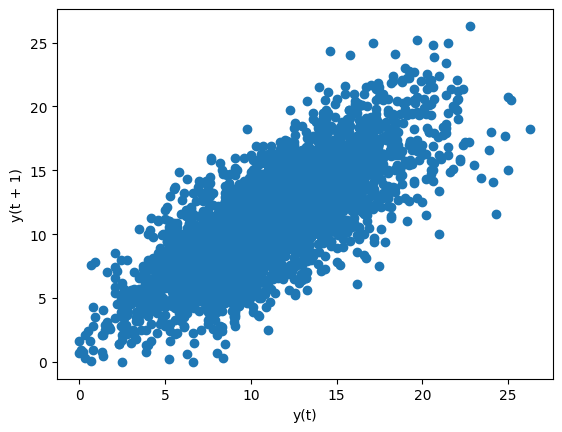

In [5]:
# lag plot of time series
from pandas.plotting import lag_plot
lag_plot(series)
plt.show()

In [6]:
# correlation of lag=1
values = pd.DataFrame(series.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
result = df.corr()
result

,t,t+1
t,1.00000,0.77487
t+1,0.77487,1.00000


#### Autocorrelation Plots

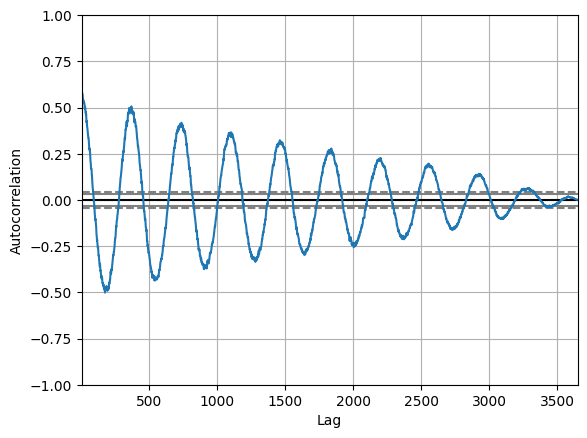

In [7]:
# autocorrelation plot of time series
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.show()

The plot provides the lag number along the x-axis and the correlation coeﬃcient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoﬀ for selecting more relevant lag values.

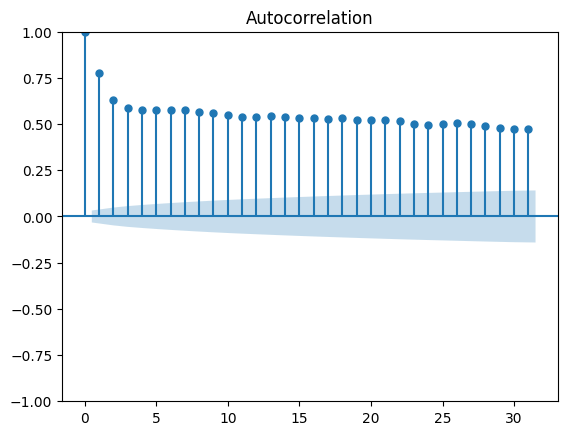

In [8]:
# autocorrelation plot of time series
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=31)
plt.show()

#### Persistence Model

Now that we know how to review the autocorrelation in our time series, let’s look at modeling it with an autoregression. Before we do that, let’s establish a baseline performance.

Let’s say that we want to develop a model to predict the last 7 days of minimum temperatures in the dataset given all prior observations. The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

We can develop a test harness for the problem by splitting the observations into training and test sets, with only the last 7 observations in the dataset assigned to the test set as unseen data that we wish to predict. The predictions are made using a walk-forward validation model so that we can persist the most recent observations for the next day. This means that we are
not making a 7-day forecast, but 7 1-day forecasts.

Test RMSE: 1.850097


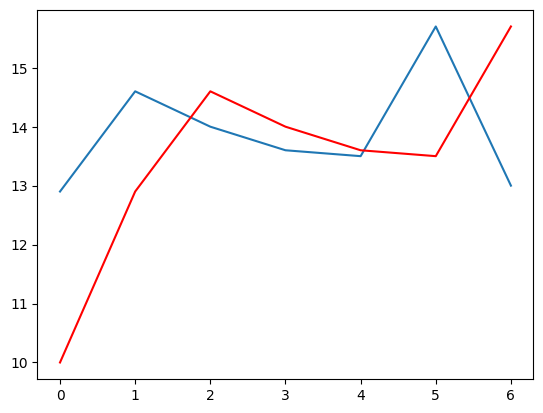

In [11]:
# evaluate a persistence model
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = pd.DataFrame(series.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']
# split into train and test sets
X = df.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:, 0], train[:, 1]
test_X, test_y = test[:, 0], test[:, 1]
# persistence model
def model_persistence(x):
  return x
# walk-forward validation
predictions = list()
for x in test_X:
  yhat = model_persistence(x)
  predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print(f'Test RMSE: {rmse:3f}')
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

#### Autoregression Model

*An autoregression model is a linear regression model that uses lagged variables as input variables.*

Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871274847727834, expected=[12.9]
predicted=13.053794217229822, expected=[14.6]
predicted=13.532590951105124, expected=[14.]
predicted=13.24312645818622, expected=[13.6]
predicted=13.091438030687984, expected=[13.5]
predicted=13.146988838852247, expected=[15.7]
predicted=13.176153455574232, expected=[13.]
Test RMSE: 1.225


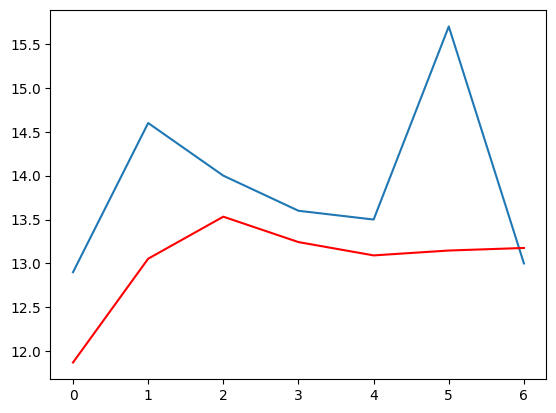

In [27]:
# create and evaluate a static autoregressive model
from statsmodels.tsa.ar_model import AutoReg
# split dataset
X = series.values
train, test = X[1: len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, 29)
model_fit = model.fit()
print(f'Coefficients: {model_fit.params}')
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
  print(f'predicted={predictions[i]}, expected={test[i]}')
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.3f}')
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=[11.87127485], expected=[12.9]
predicted=[13.65929693], expected=[14.6]
predicted=[14.34924559], expected=[14.]
predicted=[13.42745378], expected=[13.6]
predicted=[13.37487746], expected=[13.5]
predicted=[13.47999077], expected=[15.7]
predicted=[14.76514638], expected=[13.]
Test RMSE: 1.204


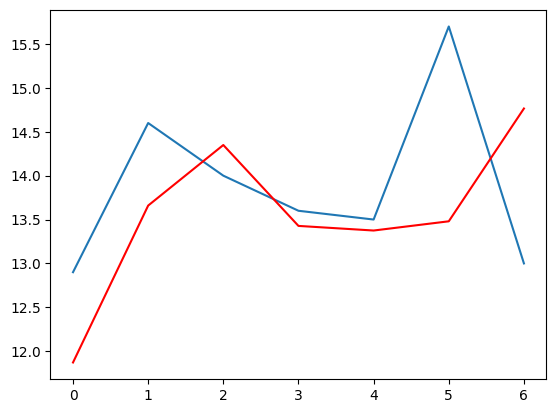

In [34]:
# create and evaluate an updated autoregressive model
window = 29
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
  length = len(history)
  lag = [history[i] for i in range(length-window, length)]
  yhat = coef[0]
  for d in range(window):
    yhat += coef[d+1] * lag[window-d-1]
  obs = test[t]
  predictions.append(yhat)
  history.append(obs)
  print(f'predicted={yhat}, expected={obs}')
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.3f}')
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()